<a href="https://colab.research.google.com/github/luquelab/tmp/blob/Colab/dynamic_regimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Regimes

## Description
This notebook identifies the different dynamic regimes of a given model when specifying an observational time. The notebook is based on ongoing research on transient dynamics by the [Luque lab](https://www.luquelab.com/) and [Rohwer lab](https://coralandphage.org/) with research scientists [Sergio Cobo-Lopez](https://scholar.google.com/citations?user=m6m1HV4AAAAJ&hl=en) and Matthew Witt as the main contributors to the project. Follow the Quick-Start Guide section to get started.

## Quick-Start Guide
Here are the recommendations to obtain results when running the notebook:
1. If it is your first time using the notebook, we recommend that you run the cells with default values. This should generate the outputs TBD.
2. Set your model in code cell TBD. You can either edit the values to build the model following the example in the cell or upload a JSON file with a previously generated model.
3. Set the observation condtions in code cell TBD.
4. Run the block TBD.
5. Check downloads and report (TBD)

# Set System and Model
This section installs any necessary packages, imports the libraries needed for the code, and defines the necessary objects to execute the notebook.

## Installations
The code below installs the necessary packages in the Colab server.

In [1]:
# Installations
## No installations needed yet.

## Imports
The code below installs the necessary libraries to run the notebook.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import json
from google.colab import files

## Definitions
The code below defines the necessary objects that have been developed specifically for this project and are necessary to generate the model and the results.

In [3]:
# Definitions

## Function that generates the system of differential equations given a model
def generate_model_system(model:dict):
  """
  Function generating a function for the differential equations of a given model.

  Args:
      model (dict): Dictionary describing the model

  Returns:
      str: Python code defining the function for the model
  """
  system = ''

  # Iterate over the dependent variables in the model
  for variable in model['variables']:

    # Load dictionary associated with the variable
    variable_dict = model['variables'][variable]

    # Chaeck is independency and accept if False
    independent = variable_dict['independent']
    if not independent:

      # Build equation for the variable
      symbol = variable_dict['symbol']
      equation = symbol+'_dot = '
      for mechanism in variable_dict['mechanisms']:
        expression = variable_dict['mechanisms'][mechanism]
        equation += expression+' '

      # Update system
      system += equation+'\n'
  return system

# Model and Conditions
This section provides the code to facilitate users to set their specific models and observational conditions of interest.

## Set Model
The code below allows users to define their specific model, which is expected to be based on a system of differential equations. The system is expected to have a single independent variable, assumed to be time.

In [6]:
# Set model
## Upload or define manually
upload = True ## Values: `True` or `False`. If True, it expects to upload model as JSON file.

if upload:
  # Upload model from JSON file
  uploaded = files.upload()
  model_bytes = next(iter(uploaded.values()))
  model = json.loads(model_bytes.decode())
  print('Model uploaded')

else:
  # Define new model

  ## Dynamic variables
  labels = ['Time','Bacteria','Phage']
  symbols = ['t','B','P']
  independency = [True,False,False]
  units = ['h','cells/ml','phage/ml']
  unit_set = {'h','cells','phage','ml'}
  initial_values = [0,100,100]

  variables = {}
  for index, label in enumerate(labels):
    symbol = symbols[index]
    unit = units[index]
    value = initial_values[index]
    independent = independency[index]
    variables[label] = {'symbol': symbol, 'unit': unit,'initial_value':value, 'independent':independent}

  ## Parameters
  labels = ['growth_constant','infection_constant_to_B','burst_size','infection_constant_from_P','decay_constant']
  symbols = ['r','dB','c','dP','m']
  independency = None
  units = ['1/h','ml/(h*phage)','phage','ml/(h*cell)','1/h']
  unit_set = {'h','ml,phage','cells','ml'}
  unit_equiv = {'cells':'cell'}
  values = [1,1,3,1,2]

  parameters = {}
  for index, label in enumerate(labels):
    symbol = symbols[index]
    unit = units[index]
    value = values[index]
    parameters[label] = {'symbol': symbol, 'unit': unit, 'value':value}


  ## Mechanisms (for each dependent variable, i.e., independency = False)
  ### Bacteria
  labels = ['growth','predation']
  expressions = ['+r*B','-a*B*P']

  mechanisms = {}
  for index, label in enumerate(labels):
    mechanism = label
    expression = expressions[index]
    mechanisms[label] = expression

  variable = 'Bacteria'
  entry = variables[variable]
  entry['mechanisms'] = mechanisms

  ### Phage
  labels = ['burst','decay']
  expressions = ['+c*a*B*P','-m*P']

  mechanisms = {}
  for index, label in enumerate(labels):
    mechanism = label
    expression = expressions[index]
    mechanisms[label] = expression

  variable = 'Phage'
  entry = variables[variable]
  entry['mechanisms'] = mechanisms

  ## OBSERVER
  ### Observational time (independent variable)
  unit = variables['Time']['unit']
  value = 10
  observation_time = {'unit': unit, 'value':value}

  ### Finite size
  unit = 'ml'
  value = 1
  system_size = {'unit':unit, 'value':value}

  ### Observer
  observer = {'observational_time': observation_time, 'system_size': system_size}

  ## MODEL
  model = {'observer':observer, 'variables':variables, 'parameteres':parameters}
  with open(f'model.json', 'w') as file:
    json.dump(model, file, indent=4)


Saving Lotka-Volterra_phage-bacteria.json to Lotka-Volterra_phage-bacteria (2).json
Model uploaded


In [7]:
model_eqs = generate_model_system(model=model)
print(model_eqs)

B_dot = +r*B -a*B*P 
P_dot = +c*a*B*P -m*P 



In [44]:

name = 'test_model'
params = 'r,a,c,m'
definition = f'def {name}(t,y,{params}):'.format(name=name, params=params)

file = open(f'{name}.py','w')

file.write(definition)
print(definition)

index = 0
for variable in model['variables']:

  # Load dictionary associated with the variable
  variable_dict = model['variables'][variable]

  # Chaeck is independency and accept if False
  independent = variable_dict['independent']
  if not independent:

    # Write equations for initial conditions
    symbol = variable_dict['symbol']
    initial = '\t' + symbol + f' = y[{index}]'.format(index=str(index))
    index += 1

    print(initial)
    file.write('\n')
    file.write(initial)


# Obtain equations as a list
eqs_list = model_eqs.split('\n')
eqs_list.remove('')
print('')

# Write system of equations
for equation in eqs_list:
  eq_line = '\t' + equation
  print(eq_line)
  file.write('\n')
  file.write(eq_line)


# Write formatted return
y_dot = 'y_dot = ['
for equation in eqs_list:

  # Obtained the symbols for the derivatives and recast to y_dot
  variable_dot = equation.split('=')[0]
  y_dot += variable_dot +','

y_dot = y_dot.rstrip(',')
y_dot += ']'
y_dot_line = '\t'+ y_dot

print('')
print(y_dot_line)
file.write('\n')
file.write(y_dot_line)


return_line = '\t'+ 'return y_dot'
print('')
print(return_line)
file.write('\n')
file.write(return_line)

file.close()



def test_model(t,y,r,a,c,m):
	B = y[0]
	P = y[1]

	B_dot = +r*B -a*B*P 
	P_dot = +c*a*B*P -m*P 

	y_dot = [B_dot ,P_dot ]

	return y_dot


In [45]:
# Copy paste output from above to test the model.
def test_model(t,y,r,a,c,m):
	B = y[0]
	P = y[1]
	B_dot = +r*B -a*B*P
	P_dot = +c*a*B*P -m*P
	y_dot = [B_dot ,P_dot ]
	return y_dot

## Set Conditions
This section allow users to define their observational time, the initial conditions for the dynamic variables, and the values of the parameters in the model.

In [7]:
# Conditions
# Not they are given when defining the model. Refactor that.

# Non abstracted approach

In [ ]:
# Model
def lotka_volterra(t, y, r, a, c, m):
  B = y[0]
  P = y[1]

  dBdt = r * B - a * B *P
  dVdt = c * a * B*P  - m*P

  dydt = [dBdt, dVdt]

  return dydt


In [46]:
# Parameters
r = 1
a = 0.5
c = 0.1
m = 2

# Conditions
B0 = 10
P0 = 10
tobs = 10
tspan = [0, tobs]
max_step = 0.01


# Dynamics
y0 = [B0, P0]
t = np.linspace(0, tobs, 1000)

# Solution
#solution = solve_ivp(lotka_volterra, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
#solution = solve_ivp(lotka_volterra_comp, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
solution = solve_ivp(test_model, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
B = solution.y[0]
P = solution.y[1]

#y = odeint(lotka_volterra, t, y0, args=(r, a, c, m))
#B = y[:, 0]
#P = y[:, 1]

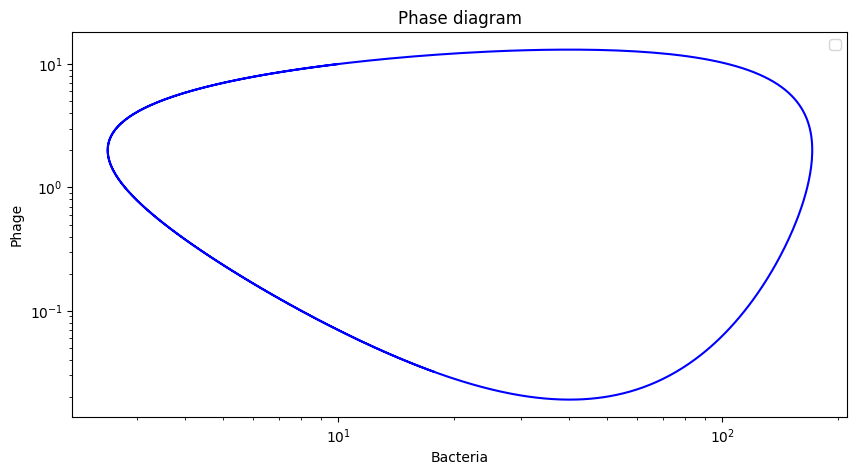

In [47]:
# Plot phase diagram dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(B[:], P[:], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Bacteria')
plt.ylabel('Phage')
plt.title('Phase diagram')
plt.legend()
plt.show()

In [ ]:
# Model
def lotka_volterra(y, t, r, a, c, m):
  B = y[0]
  P = y[1]

  dBdt = r * B - a * B *P
  dVdt = c * a * B*P  - m*P

  dydt = [dBdt, dVdt]

  return dydt


In [ ]:
# Parameters
r = 1
a = 0.5
c = 0.1
m = 2

In [ ]:
# Conditions
B0 = 10
P0 = 10
tobs = 10

In [ ]:
# Dynamics
y0 = [B0, P0]
t = np.linspace(0, tobs, 1000)

# Solution
y = odeint(lotka_volterra, y0, t, args=(r, a, c, m))

B = y[:, 0]
P = y[:, 1]

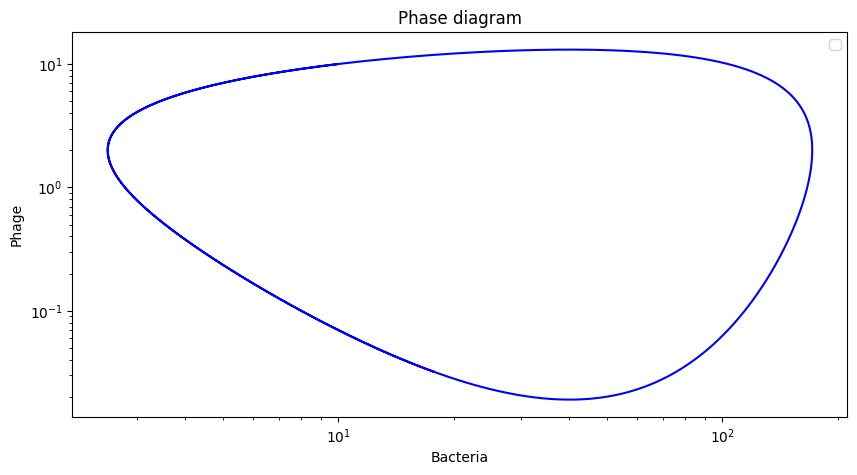

In [ ]:
# Plot phase diagram dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(B[:], P[:], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Bacteria')
plt.ylabel('Phage')
plt.title('Phase diagram')
plt.legend()
plt.show()

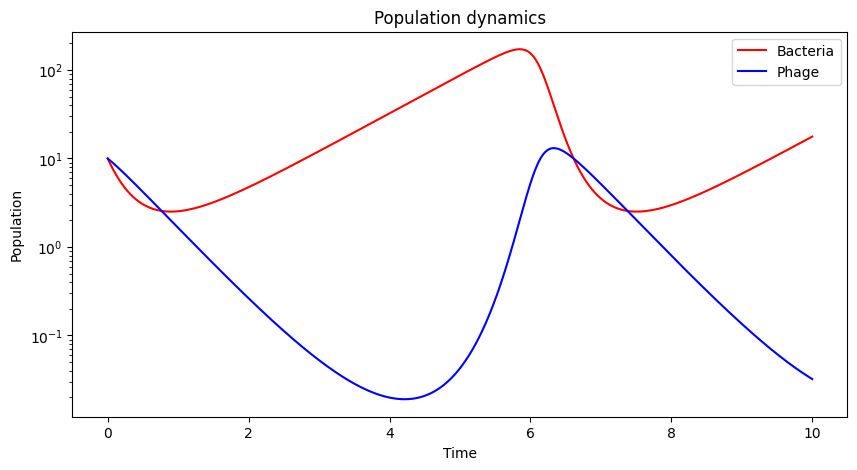

In [ ]:
# Plot individual dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(t, B, 'r-', label='Bacteria')
plt.plot(t, P, 'b-', label='Phage')
ax.set_yscale('log')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population dynamics')
plt.legend()
plt.show()

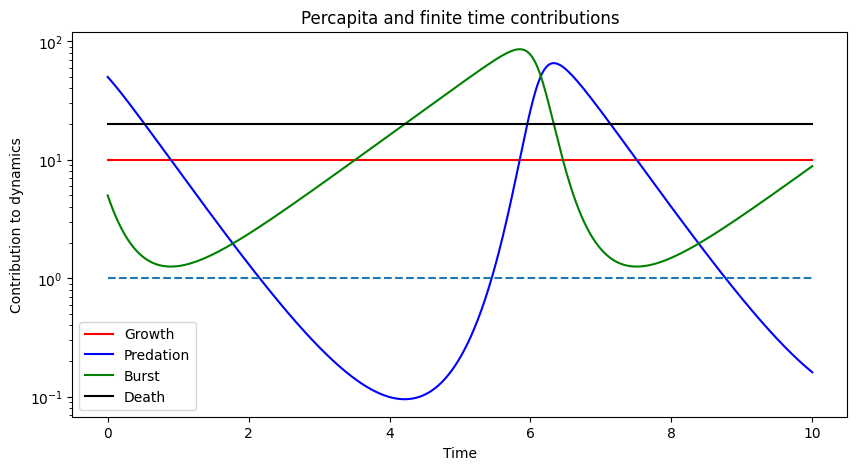

In [ ]:
# Plot impact of indiviual mechanisms

## Mechanisms
growth = r*B
predation = a*B*P
burst = c*a*B*P
death = m*P

## Percapita and time finit
growth_per_B = tobs*growth/B
predation_per_B = tobs*predation/B
burst_per_P = tobs*burst/P
death_per_P = tobs*death/P

## Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(t, growth_per_B, 'r-', label='Growth')
plt.plot(t, predation_per_B, 'b-', label='Predation')
plt.plot(t, burst_per_P, 'g-', label='Burst')
plt.plot(t, death_per_P, 'k-', label='Death')
ax.hlines(1, 0, tobs, linestyles='dashed')
ax.set_yscale('log')
plt.xlabel('Time')
plt.ylabel('Contribution to dynamics')
plt.title('Percapita and finite time contributions')
plt.legend()
plt.show()

In [ ]:
# prompt: Use the simpy package to generate the Lotka-Volterra model used above to display the mathematical equations. No need to solve them.

import simpy

# Define the model
model = simpy.Environment()

# Define the parameters
r = 1
a = 0.5
c = 0.1
m = 2

# Define the states
B = simpy.Container(model, initial_value=10)
P = simpy.Container(model, initial_value=10)

# Define the processes
def growth(env, b, p):
  while True:
    yield env.timeout(1)
    b.level += r * b.level

def predation(env, b, p):
  while True:
    yield env.timeout(1)
    b.level -= a * b.level * p.level

def burst(env, b, p):
  while True:
    yield env.timeout(1)
    p.level += c * a * b.level * p.level

def death(env, p):
  while True:
    yield env.timeout(1)
    p.level -= m * p.level

# Run the simulation
model.run(until=10)

# Print the results
print(B.level)
print(P.level)


ModuleNotFoundError: ignored